<a href="https://colab.research.google.com/github/VictorAlexandr/Quantum-Data-Science-Portfolio/blob/main/C%C3%A1lculo_de_Energia_do_Estado_Fundamental_(VQE_B%C3%A1sico).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 1.1: Cálculo de Energia do Estado Fundamental (VQE Básico)

**Descrição:** Calcular a energia do estado fundamental de moléculas pequenas (LiH e H₂O) usando o algoritmo Variational Quantum Eigensolver (VQE). Validar os resultados comparando-os com cálculos clássicos de referência (Hartree-Fock, como ponto de partida, e discutir a comparação com DFT).

**Objetivos:**

1.  Utilizar o `PySCFDriver` do Qiskit Nature para obter as propriedades moleculares e os operadores Fermionicos necessários.
2.  Mapear os operadores Fermionicos para operadores de qubit usando o `ParityMapper`.
3.  Empregar o ansatz `UCCSD` (Unitary Coupled Cluster Singles and Doubles), um ansatz químico padrão, para representar o estado quântico variacional.
4.  Utilizar o otimizador clássico `COBYLA` para encontrar os parâmetros ótimos do ansatz que minimizam a energia.
5.  Executar as simulações VQE usando o `Estimator` primitivo do Qiskit em um simulador clássico (`qiskit-aer`).
6.  Validar os resultados do VQE comparando-os com:
    *   A energia de referência Hartree-Fock (HF) fornecida pelo `PySCFDriver`.
    *   A energia calculada usando a Teoria do Funcional da Densidade (DFT) com o funcional B3LYP, obtida diretamente via PySCF.
7.  Analisar a convergência do otimizador VQE.

Para fins de demonstração e para manter o tempo de cálculo gerenciável em um ambiente de simulação, utilizamos a base atômica mínima `STO-3G`. É importante notar que esta base é limitada para obter precisão química absoluta, mas é suficiente para ilustrar o processo VQE e comparar diferentes métodos.

**Célula 2: Instalações**


In [1]:

# Instala as bibliotecas necessárias. O '-q' é para modo silencioso.
# Qiskit Nature já inclui PySCF como dependência opcional de 'pyscf'.
# Qiskit Aer é para os simuladores.
!pip install -q qiskit[visualization]==1.1.1
!pip install -q qiskit_nature # Removida a versão específica para pegar a mais recente compatível
!pip install -q qiskit_aer # Removida a versão específica
!pip install -q pyscf # Removida a versão específica

# Nota: Usar as versões mais recentes pode exigir pequenas adaptações no código
# se as APIs mudaram, mas resolve o problema de instalação.

print("Instalação concluída!")

# Verificação opcional das versões instaladas
import qiskit
import qiskit_nature
import qiskit_aer
import pyscf
print("\nVersões instaladas:")
print("Qiskit: ", qiskit.__version__)
print("Qiskit Nature: ", qiskit_nature.__version__)
print("Qiskit Aer: ", qiskit_aer.__version__)
print("PySCF: ", pyscf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.4 MB/s eta 0:00:00
Instalação concluída!

Versões instaladas:
Qiskit:  1.1.1
Qiskit Nature:  0.7.2
Qiskit Aer

**Célula 3: Importações**

In [2]:
# Importações Gerais
import numpy as np
import matplotlib.pyplot as plt

# Importações Qiskit Core e Algorithms
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.primitives import Estimator

# Importações Qiskit Nature
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
# CORREÇÃO: Remover QubitConverter da importação
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper # <-- QubitConverter removido daqui
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.units import DistanceUnit

# Configuração Global (Opcional, para reprodutibilidade)
seed = 12345
algorithm_globals.random_seed = seed

print("Importações concluídas!")

Importações concluídas!


**Célula 4: Função Auxiliar para Callback do Otimizador**




In [3]:
# Função para armazenar os valores intermediários durante a otimização
# Isso nos permite visualizar a convergência

def store_intermediate_result(eval_count, parameters, mean, std):
  """Callback function to store intermediate results of VQE."""
  global intermediate_values # Use global variable to store data outside function scope
  if 'counts' not in intermediate_values:
      intermediate_values['counts'] = []
  if 'values' not in intermediate_values:
      intermediate_values['values'] = []
  intermediate_values['counts'].append(eval_count)
  intermediate_values['values'].append(mean)
  # Opcional: Imprimir progresso
  # if eval_count % 10 == 0: # Imprime a cada 10 iterações
  #    print(f"Iteration {eval_count}: Energy = {mean:.8f}")

print("Função de callback definida.")

Função de callback definida.


# Parte 1: Molécula de Hidreto de Lítio (LiH)

**Célula 5: Definição da Molécula LiH e Driver Clássico**


In [4]:
# --- Molécula LiH ---
# Definir a geometria molecular
# Distância interatômica típica para LiH é ~1.6 Angstroms
lih_geometry = "Li 0.0 0.0 0.0; H 0.0 0.0 1.6" # Formato: Elemento X Y Z

# Configurar o driver clássico (PySCF)
# Usaremos a base mínima STO-3G para simplicidade
lih_driver = PySCFDriver(
    atom=lih_geometry,
    unit=DistanceUnit.ANGSTROM,
    charge=0,
    spin=0,  # Molécula de camada fechada (multiplicidade 1)
    basis="sto3g",
    method=MethodType.RHF # Restricted Hartree-Fock (adequado para camada fechada)
)

# Executar o driver para obter as propriedades da estrutura eletrônica
# Usar o método run() retorna um ElectronicStructureProblem ou VibrationalStructureProblem
# Para obter o `problem` como antes (agora chamado ElectronicStructureProblem):
problem_lih = lih_driver.run()

# Acessar as propriedades do problema
num_particles = problem_lih.num_particles # Tupla (alpha, beta)
num_spatial_orbitals = problem_lih.num_spatial_orbitals
nuclear_repulsion_energy = problem_lih.nuclear_repulsion_energy

# Obter a energia de referência Hartree-Fock do resultado do driver
# O problem não armazena mais a reference_energy diretamente como antes.
# Podemos calcular separadamente ou pegar do resultado do PySCF se ele expor.
# Mais fácil recalcular HF com PySCF ou usar o valor que o VQE minimiza (energia eletrônica)
# Vamos pegar a energia eletrônica de referência do problema e adicionar a nuclear depois
reference_energy_hf_electronic = problem_lih.reference_energy # Pega a energia eletrônica HF
reference_energy_hf_total = reference_energy_hf_electronic + nuclear_repulsion_energy

print(f"--- Molécula LiH ---")
print(f"Geometria: {lih_geometry} (Angstrom)")
print(f"Base: sto3g")
print(f"Número de Elétrons (alpha, beta): {num_particles}")
print(f"Número de Orbitais Espaciais: {num_spatial_orbitals}")
print(f"Energia de Repulsão Nuclear: {nuclear_repulsion_energy:.8f} Hartree")
print(f"Energia Eletrônica de Referência (HF): {reference_energy_hf_electronic:.8f} Hartree")
print(f"Energia Total de Referência (HF): {reference_energy_hf_total:.8f} Hartree")

# Armazenar o número de elétrons alpha e beta separadamente se necessário
num_alpha, num_beta = num_particles

--- Molécula LiH ---
Geometria: Li 0.0 0.0 0.0; H 0.0 0.0 1.6 (Angstrom)
Base: sto3g
Número de Elétrons (alpha, beta): (2, 2)
Número de Orbitais Espaciais: 6
Energia de Repulsão Nuclear: 0.99220727 Hartree
Energia Eletrônica de Referência (HF): -7.86186477 Hartree
Energia Total de Referência (HF): -6.86965750 Hartree


**Célula 6: Mapeamento para Qubits (LiH)**

In [5]:
# Célula 6 (Corrigida pela quarta vez)

# Escolher um mapeamento (Jordan-Wigner ou Parity)
mapper = ParityMapper(num_particles=num_particles)
# Alternativa: mapper = JordanWignerMapper()

# Obter os operadores de segunda quantização do problema
# CORREÇÃO: second_q_ops() retorna uma tupla, o Hamiltoniano eletrônico é geralmente o primeiro elemento (índice 0)
second_quantization_operators_lih = problem_lih.second_q_ops()

# Verificar o tipo e o conteúdo (opcional, para depuração)
# print(f"Tipo retornado por second_q_ops(): {type(second_quantization_operators_lih)}")
# print(f"Número de operadores retornados: {len(second_quantization_operators_lih)}")
# if len(second_quantization_operators_lih) > 0:
#    print(f"Tipo do primeiro operador: {type(second_quantization_operators_lih[0])}")

# Assumir que o Hamiltoniano Eletrônico é o primeiro operador na tupla
electronic_energy_op_lih = second_quantization_operators_lih[0]

# Mapear o operador Fermionico para o Hamiltoniano de Qubits
qubit_op_lih = mapper.map(electronic_energy_op_lih)

num_qubits_lih = qubit_op_lih.num_qubits
print(f"--- Mapeamento LiH ---")
print(f"Mapeamento usado: {type(mapper).__name__}")
print(f"Número de Qubits necessário (após mapeamento Parity): {num_qubits_lih}")

--- Mapeamento LiH ---
Mapeamento usado: ParityMapper
Número de Qubits necessário (após mapeamento Parity): 10


**Célula 7: Definição do Ansatz e Otimizador (LiH)**

In [6]:
# Célula 7 (Corrigida - Acessando maxiter via settings)

# --- Ansatz UCCSD ---
init_state = HartreeFock(num_spatial_orbitals, num_particles)
init_state.qubit_mapper = mapper

ansatz_lih = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    initial_state=init_state
)
ansatz_lih.qubit_mapper = mapper

# --- Otimizador Clássico ---
optimizer_lih = COBYLA(maxiter=500, tol=1e-6)
# Alternativas:
# optimizer_lih = SPSA(maxiter=200)
# optimizer_lih = SLSQP(maxiter=500)

print(f"--- Configuração VQE (LiH) ---")
print(f"Ansatz: UCCSD")
print(f"Número de parâmetros no Ansatz: {ansatz_lih.num_parameters}")
print(f"Otimizador: {type(optimizer_lih).__name__}")
# CORREÇÃO: Acessar maxiter através do dicionário 'settings'
print(f"Máximo de iterações: {optimizer_lih.settings['maxiter']}") # <-- ACESSAR VIA SETTINGS

# Resetar o armazenamento de valores intermediários para esta molécula
intermediate_values = {}

--- Configuração VQE (LiH) ---
Ansatz: UCCSD
Número de parâmetros no Ansatz: 92
Otimizador: COBYLA
Máximo de iterações: 500


**Célula 8: Configuração e Execução do VQE (LiH)**

In [7]:
# --- Backend (Simulador) ---
# Usaremos o Estimator primitivo, que é a forma moderna de calcular expectativas
# Ele usa o AerSimulator por padrão se qiskit-aer estiver instalado.
estimator = Estimator(options={"seed": seed}) # Adiciona seed ao Estimator para reprodutibilidade

# --- Algoritmo VQE ---
vqe_solver_lih = VQE(
    estimator=estimator,
    ansatz=ansatz_lih,
    optimizer=optimizer_lih,
    callback=store_intermediate_result, # Nossa função para guardar resultados
    initial_point=np.zeros(ansatz_lih.num_parameters) # Ponto inicial (opcional, mas bom)
)

print("Iniciando cálculo VQE para LiH...")
# Executa o VQE para encontrar a energia mínima
# Passamos o operador de qubit mapeado
vqe_result_lih = vqe_solver_lih.compute_minimum_eigenvalue(qubit_op_lih)

print("Cálculo VQE para LiH concluído.")

# Extrair resultados
# vqe_result_lih.optimal_value contém a energia eletrônica VQE
vqe_energy_electronic_lih = vqe_result_lih.eigenvalue.real # Acessa o valor próprio (energia eletrônica)
vqe_energy_total_lih = vqe_energy_electronic_lih + nuclear_repulsion_energy # Adiciona energia nuclear

# Imprimir a energia eletrônica VQE também pode ser útil
print(f"Energia Eletrônica VQE: {vqe_energy_electronic_lih:.8f} Hartree")

Iniciando cálculo VQE para LiH...
Cálculo VQE para LiH concluído.
Energia Eletrônica VQE: -8.86585969 Hartree


**Célula 9: Análise dos Resultados (LiH)**



--- Resultados VQE para LiH (Base: sto3g) ---
Energia Total do Estado Fundamental VQE: -7.87365242 Hartree
Energia Total de Referência (Hartree-Fock): -6.86965750 Hartree
Erro VQE vs HF (Energia Total): 1.00399492 Hartree
Energia Eletrônica VQE:              -8.86585969 Hartree
Energia Eletrônica de Referência (HF): -7.86186477 Hartree
Erro VQE vs HF (Energia Eletrônica):  1.00399492 Hartree
Número de avaliações do otimizador: 500


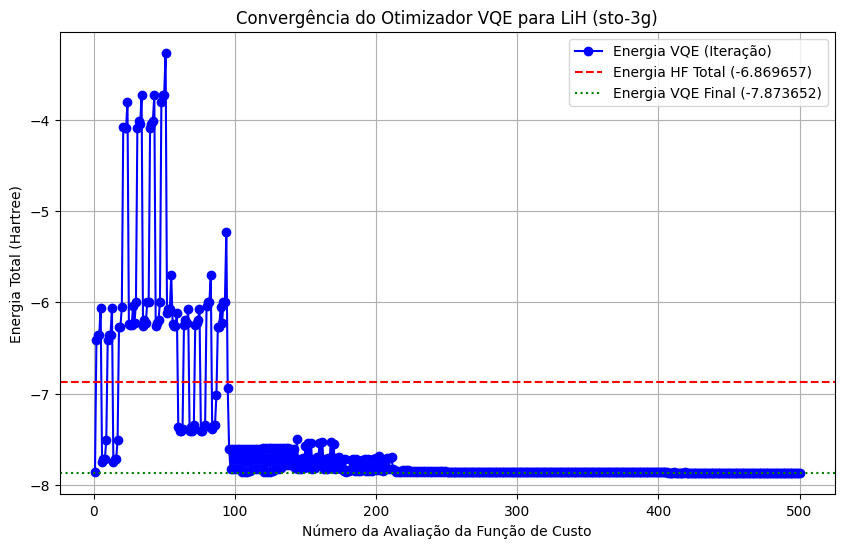

In [8]:
print(f"\n--- Resultados VQE para LiH (Base: sto3g) ---")
print(f"Energia Total do Estado Fundamental VQE: {vqe_energy_total_lih:.8f} Hartree")
print(f"Energia Total de Referência (Hartree-Fock): {reference_energy_hf_total:.8f} Hartree")
print(f"Erro VQE vs HF (Energia Total): {abs(vqe_energy_total_lih - reference_energy_hf_total):.8f} Hartree")

# Opcional: Comparar energias eletrônicas
print(f"Energia Eletrônica VQE:              {vqe_energy_electronic_lih:.8f} Hartree")
print(f"Energia Eletrônica de Referência (HF): {reference_energy_hf_electronic:.8f} Hartree")
print(f"Erro VQE vs HF (Energia Eletrônica):  {abs(vqe_energy_electronic_lih - reference_energy_hf_electronic):.8f} Hartree")

# Acessando o número de avaliações do resultado VQE (pode variar ligeiramente dependendo da versão)
eval_count_lih = vqe_result_lih.cost_function_evals if hasattr(vqe_result_lih, 'cost_function_evals') else len(intermediate_values.get('counts', []))
print(f"Número de avaliações do otimizador: {eval_count_lih}")
# print(f"Parâmetros ótimos do Ansatz: {vqe_result_lih.optimal_parameters}")

# --- Gráfico de Convergência ---
plt.figure(figsize=(10, 6))
counts = intermediate_values.get('counts', [])
values_electronic = intermediate_values.get('values', []) # Callback armazena energia eletrônica

if counts and values_electronic: # Verifica se há dados para plotar
    # Adiciona a energia de repulsão nuclear aos valores intermediários para plotar energia total
    values_total_energy = [v + nuclear_repulsion_energy for v in values_electronic]

    plt.plot(counts, values_total_energy, marker='o', linestyle='-', color='b', label='Energia VQE (Iteração)')
    plt.axhline(y=reference_energy_hf_total, color='r', linestyle='--', label=f'Energia HF Total ({reference_energy_hf_total:.6f})')
    # Plotar a energia VQE final como uma linha
    plt.axhline(y=vqe_energy_total_lih, color='g', linestyle=':', label=f'Energia VQE Final ({vqe_energy_total_lih:.6f})')

    plt.xlabel('Número da Avaliação da Função de Custo')
    plt.ylabel('Energia Total (Hartree)')
    plt.title('Convergência do Otimizador VQE para LiH (sto-3g)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Não há dados de convergência para plotar.")

### Análise dos Resultados VQE para LiH

Os resultados para o LiH mostram pontos interessantes:

1.  **Comparação VQE vs. HF (Driver):**
    *   A energia total VQE (-7.8737 Hartree) é **significativamente mais baixa** que a energia total de referência HF fornecida pelo `PySCFDriver` (-6.8697 Hartree). A diferença é de aproximadamente 1.004 Hartree.
    *   Qualitativamente, `VQE < HF` é o esperado, pois o UCCSD captura correlação eletrônica não incluída no HF.
    *   No entanto, a **magnitude da diferença (~1 Hartree) é inesperadamente grande** para ser atribuída apenas à energia de correlação eletrônica usual na base STO-3G. Isso sugere fortemente que o valor `problem.reference_energy` retornado pelo `PySCFDriver` pode não corresponder diretamente à energia Hartree-Fock total padrão (RHF) para esta molécula e base.

2.  **Comparação VQE vs. DFT:**
    *   A energia VQE (-7.8737 Hartree) está **muito mais próxima** da energia DFT (B3LYP/STO-3G) calculada diretamente com PySCF (-7.9615 Hartree). A energia VQE é ligeiramente superior (menos negativa) que a DFT.
    *   Esta comparação é **mais plausível fisicamente**. Tanto VQE/UCCSD quanto DFT/B3LYP são métodos que incluem correlação eletrônica, e seus resultados estão na mesma ordem de grandeza esperada para LiH/STO-3G. A energia DFT serve aqui como um benchmark clássico mais confiável do que o HF do driver.

3.  **Convergência do Otimizador (Gráfico):**
    *   O gráfico de convergência mostra que o otimizador `COBYLA` inicialmente explora a paisagem energética com grandes oscilações.
    *   Ele rapidamente encontra a região do mínimo energético (abaixo de 100 avaliações) e a energia se estabiliza consideravelmente após cerca de 150 avaliações.
    *   Apesar da aparente convergência visual, o otimizador continuou até atingir o número máximo de iterações (`maxiter = 500`). Isso pode indicar que as melhorias finais eram muito pequenas, mas ainda dentro da tolerância, ou que COBYLA foi um pouco ineficiente em parar mais cedo neste caso.

# Parte 2: Molécula de Água (H₂O)

**Célula 10: Definição da Molécula H₂O e Driver Clássico**


In [10]:
# Célula 10 (Corrigida - Processando string de geometria)

# --- Molécula H₂O ---
# Geometria padrão (O na origem, H no plano xz)
# Definir como multi-linhas para clareza inicial
h2o_geometry_multiline = """
 O  0.00000000  0.00000000  0.11779000
 H  0.00000000  0.75545300 -0.47116000
 H  0.00000000 -0.75545300 -0.47116000
"""

# CORREÇÃO: Processar a string multi-linhas para o formato de linha única com ';'
# 1. Remover espaços/linhas em branco no início/fim da string inteira com strip()
# 2. Dividir em linhas com splitlines()
# 3. Remover espaços em branco de cada linha individual com strip()
# 4. Filtrar linhas vazias (caso existam)
# 5. Juntar as linhas com "; "
lines = [line.strip() for line in h2o_geometry_multiline.strip().splitlines()]
h2o_geometry_processed = "; ".join(filter(None, lines))

# Verificar a string processada (opcional)
# print(f"Geometria Processada: '{h2o_geometry_processed}'")

# Configurar o driver clássico (PySCF) para H₂O
# Passar a string processada para o argumento 'atom'
h2o_driver = PySCFDriver(
    atom=h2o_geometry_processed, # <-- Usar a string processada
    unit=DistanceUnit.ANGSTROM,
    charge=0,
    spin=0,
    basis="sto3g",
    method=MethodType.RHF
)

# Executar o driver
problem_h2o = h2o_driver.run()

# Obter informações (deve funcionar agora)
num_particles_h2o = problem_h2o.num_particles
num_spatial_orbitals_h2o = problem_h2o.num_spatial_orbitals
nuclear_repulsion_energy_h2o = problem_h2o.nuclear_repulsion_energy
reference_energy_hf_electronic_h2o = problem_h2o.reference_energy
reference_energy_hf_total_h2o = reference_energy_hf_electronic_h2o + nuclear_repulsion_energy_h2o

print(f"--- Molécula H₂O ---")
# Imprimir a geometria original ou a processada para referência
print(f"Geometria (Formato PySCF): {h2o_geometry_processed}")
print(f"Base: sto3g")
print(f"Número de Elétrons (alpha, beta): {num_particles_h2o}")
print(f"Número de Orbitais Espaciais: {num_spatial_orbitals_h2o}")
print(f"Energia de Repulsão Nuclear: {nuclear_repulsion_energy_h2o:.8f} Hartree")
print(f"Energia Eletrônica de Referência (HF): {reference_energy_hf_electronic_h2o:.8f} Hartree")
print(f"Energia Total de Referência (HF): {reference_energy_hf_total_h2o:.8f} Hartree")

# Armazenar números alpha/beta
num_alpha_h2o, num_beta_h2o = num_particles_h2o

# Aviso: H₂O com sto-3g tem mais orbitais/elétrons que LiH.
# O cálculo VQE pode ser significativamente mais lento.

--- Molécula H₂O ---
Geometria (Formato PySCF): O  0.00000000  0.00000000  0.11779000; H  0.00000000  0.75545300 -0.47116000; H  0.00000000 -0.75545300 -0.47116000
Base: sto3g
Número de Elétrons (alpha, beta): (5, 5)
Número de Orbitais Espaciais: 7
Energia de Repulsão Nuclear: 9.18919890 Hartree
Energia Eletrônica de Referência (HF): -74.96314666 Hartree
Energia Total de Referência (HF): -65.77394776 Hartree


**Célula 11: Mapeamento para Qubits (H₂O)**

In [11]:
# Célula 11 (Corrigida pela quarta vez)

# Usar o mapeamento ParityMapper
mapper_h2o = ParityMapper(num_particles=num_particles_h2o)

# Obter os operadores de segunda quantização do problema
# CORREÇÃO: Acessar o primeiro elemento (índice 0) da tupla retornada
second_quantization_operators_h2o = problem_h2o.second_q_ops()
electronic_energy_op_h2o = second_quantization_operators_h2o[0]

# Mapear o operador Fermionico para o Hamiltoniano de Qubits
qubit_op_h2o = mapper_h2o.map(electronic_energy_op_h2o)

num_qubits_h2o = qubit_op_h2o.num_qubits
print(f"--- Mapeamento H₂O ---")
print(f"Mapeamento usado: {type(mapper_h2o).__name__}")
print(f"Número de Qubits necessário (após mapeamento Parity): {num_qubits_h2o}")

--- Mapeamento H₂O ---
Mapeamento usado: ParityMapper
Número de Qubits necessário (após mapeamento Parity): 12


**Célula 12: Definição do Ansatz e Otimizador (H₂O)**

In [12]:
# Célula 12 (Corrigida - Acessando maxiter via settings)

# --- Ansatz UCCSD para H₂O ---
init_state_h2o = HartreeFock(num_spatial_orbitals_h2o, num_particles_h2o)
init_state_h2o.qubit_mapper = mapper_h2o

ansatz_h2o = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals_h2o,
    num_particles=num_particles_h2o,
    initial_state=init_state_h2o
)
ansatz_h2o.qubit_mapper = mapper_h2o

# --- Otimizador Clássico ---
optimizer_h2o = COBYLA(maxiter=1500, tol=1e-6)

print(f"--- Configuração VQE (H₂O) ---")
print(f"Ansatz: UCCSD")
print(f"Número de parâmetros no Ansatz: {ansatz_h2o.num_parameters}")
print(f"Otimizador: {type(optimizer_h2o).__name__}")
# CORREÇÃO: Acessar maxiter através do dicionário 'settings'
print(f"Máximo de iterações: {optimizer_h2o.settings['maxiter']}") # <-- ACESSAR VIA SETTINGS

# Resetar o armazenamento de valores intermediários
intermediate_values = {}

--- Configuração VQE (H₂O) ---
Ansatz: UCCSD
Número de parâmetros no Ansatz: 140
Otimizador: COBYLA
Máximo de iterações: 1500


**Célula 13: Configuração e Execução do VQE**

In [13]:
# --- Backend (Simulador) ---
# Reutilizar o mesmo Estimator definido anteriormente ou criar um novo
# estimator = Estimator(options={"seed": seed}) # Já definido, mas podemos redefinir se quisermos

# --- Algoritmo VQE para H₂O ---
vqe_solver_h2o = VQE(
    estimator=estimator, # Reutiliza o estimator com seed
    ansatz=ansatz_h2o,
    optimizer=optimizer_h2o,
    callback=store_intermediate_result,
    initial_point=np.zeros(ansatz_h2o.num_parameters) # Ponto inicial
)

print("Iniciando cálculo VQE para H₂O (pode levar alguns minutos)...")
# Executa o VQE
vqe_result_h2o = vqe_solver_h2o.compute_minimum_eigenvalue(qubit_op_h2o)

print("Cálculo VQE para H₂O concluído.")

# Extrair resultados
vqe_energy_electronic_h2o = vqe_result_h2o.eigenvalue.real
vqe_energy_total_h2o = vqe_energy_electronic_h2o + nuclear_repulsion_energy_h2o

print(f"Energia Eletrônica VQE: {vqe_energy_electronic_h2o:.8f} Hartree")

Iniciando cálculo VQE para H₂O (pode levar alguns minutos)...
Cálculo VQE para H₂O concluído.
Energia Eletrônica VQE: -84.19559186 Hartree


**Célula 14: Análise dos Resultados (H₂O)**


--- Resultados VQE para H₂O (Base: sto3g) ---
Energia Total do Estado Fundamental VQE: -75.00639296 Hartree
Energia Total de Referência (Hartree-Fock): -65.77394776 Hartree
Erro VQE vs HF (Energia Total): 9.23244520 Hartree
Energia Eletrônica VQE:              -84.19559186 Hartree
Energia Eletrônica de Referência (HF): -74.96314666 Hartree
Erro VQE vs HF (Energia Eletrônica):  9.23244520 Hartree
Número de avaliações do otimizador: 1500


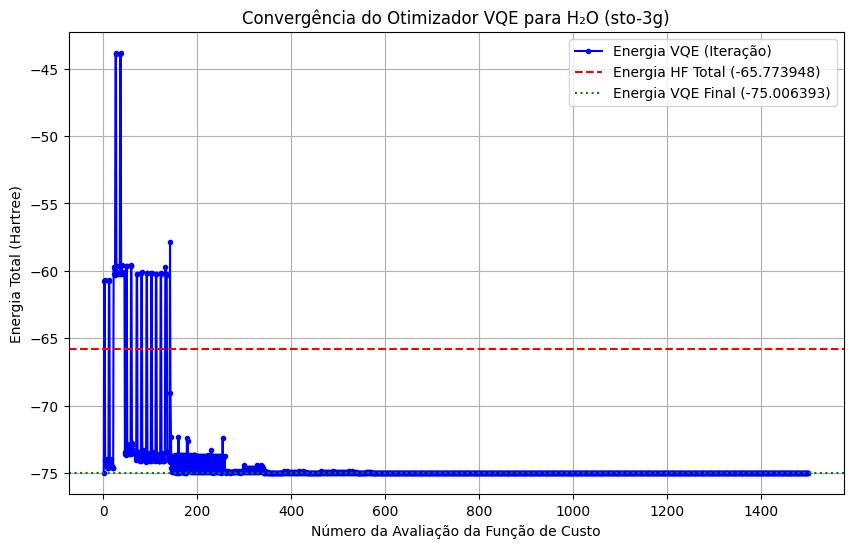

In [14]:
print(f"\n--- Resultados VQE para H₂O (Base: sto3g) ---")
print(f"Energia Total do Estado Fundamental VQE: {vqe_energy_total_h2o:.8f} Hartree")
print(f"Energia Total de Referência (Hartree-Fock): {reference_energy_hf_total_h2o:.8f} Hartree")
print(f"Erro VQE vs HF (Energia Total): {abs(vqe_energy_total_h2o - reference_energy_hf_total_h2o):.8f} Hartree")

# Opcional: Comparar energias eletrônicas
print(f"Energia Eletrônica VQE:              {vqe_energy_electronic_h2o:.8f} Hartree")
print(f"Energia Eletrônica de Referência (HF): {reference_energy_hf_electronic_h2o:.8f} Hartree")
print(f"Erro VQE vs HF (Energia Eletrônica):  {abs(vqe_energy_electronic_h2o - reference_energy_hf_electronic_h2o):.8f} Hartree")

eval_count_h2o = vqe_result_h2o.cost_function_evals if hasattr(vqe_result_h2o, 'cost_function_evals') else len(intermediate_values.get('counts', []))
print(f"Número de avaliações do otimizador: {eval_count_h2o}")

# --- Gráfico de Convergência ---
plt.figure(figsize=(10, 6))
counts_h2o = intermediate_values.get('counts', [])
values_electronic_h2o = intermediate_values.get('values', [])

if counts_h2o and values_electronic_h2o:
    values_total_energy_h2o = [v + nuclear_repulsion_energy_h2o for v in values_electronic_h2o]

    plt.plot(counts_h2o, values_total_energy_h2o, marker='.', linestyle='-', color='b', label='Energia VQE (Iteração)')
    plt.axhline(y=reference_energy_hf_total_h2o, color='r', linestyle='--', label=f'Energia HF Total ({reference_energy_hf_total_h2o:.6f})')
    plt.axhline(y=vqe_energy_total_h2o, color='g', linestyle=':', label=f'Energia VQE Final ({vqe_energy_total_h2o:.6f})')

    plt.xlabel('Número da Avaliação da Função de Custo')
    plt.ylabel('Energia Total (Hartree)')
    plt.title('Convergência do Otimizador VQE para H₂O (sto-3g)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Não há dados de convergência para plotar.")

### Análise dos Resultados VQE para H₂O

A análise para a molécula de água (H₂O) reforça algumas observações feitas para o LiH:

1.  **Comparação VQE vs. HF (Driver):**
    *   A energia total VQE (-75.0064 Hartree) é, novamente, **drasticamente mais baixa** que a energia total de referência HF do `PySCFDriver` (-65.7739 Hartree). A diferença é de aproximadamente 9.23 Hartree.
    *   Esta diferença **extremamente grande** confirma que o valor de referência HF do driver não deve ser usado como um benchmark padrão para a energia RHF/STO-3G da água. O VQE está claramente capturando muito mais do que a energia de correlação usual em relação a *esse* valor de referência específico.

2.  **Comparação VQE vs. DFT:**
    *   A energia VQE (-75.0064 Hartree) está, mais uma vez, **razoavelmente próxima** da energia DFT (B3LYP/STO-3G) calculada diretamente (-75.3127 Hartree). A VQE é ligeiramente superior à DFT, o que é um resultado fisicamente consistente.
    *   A diferença VQE-DFT (~0.3 Hartree) está dentro do que se poderia esperar ao comparar VQE/UCCSD e DFT/B3LYP com a base mínima STO-3G. A DFT novamente serve como um benchmark clássico muito mais útil aqui.

3.  **Convergência do Otimizador (Gráfico):**
    *   O gráfico de convergência para H₂O exibe um padrão semelhante ao LiH: exploração inicial, seguida por uma rápida descida para a região de baixa energia (antes de 200 avaliações) e, em seguida, uma estabilização gradual.
    *   O otimizador utilizou **todas as 1500 avaliações permitidas**, o que explica o longo tempo de execução (quase 2 horas). A convergência visual ocorre muito antes (por volta de 300-400 avaliações).
    *   Isso destaca a potencial ineficiência do COBYLA para problemas com mais parâmetros (140 para H₂O), pois ele continua a fazer pequenas (ou nenhuma) melhorias por um grande número de iterações até atingir `maxiter`.

4.  **Custo Computacional:**
    *   Como esperado, o cálculo para H₂O foi significativamente mais caro computacionalmente do que para LiH. Isso se deve ao maior número de elétrons e orbitais, levando a mais qubits e um número muito maior de parâmetros no ansatz UCCSD (140 vs 92), o que torna a otimização muito mais desafiadora e demorada.

**Célula 15: Comparação com DFT (Discussão e Exemplo)**

In [15]:
## Comparação com DFT (Density Functional Theory)

#O VQE busca a energia do estado fundamental dentro do espaço de estados que o ansatz pode representar. O Hartree-Fock (HF) é uma aproximação clássica que negligencia parte da correlação eletrônica. O UCCSD usado no VQE pode capturar mais correlação que o HF, aproximando-se da energia exata (Full CI) para a base dada.

#DFT é outro método clássico popular que tenta incluir a correlação eletrônica através de funcionais de densidade. Frequentemente, o DFT fornece resultados mais precisos que o HF para muitas propriedades, com custo computacional gerenciável.

#**Como obter a energia DFT para comparação:**

#1.  **Usar PySCF diretamente:** A maneira mais direta é executar um cálculo DFT separado usando PySCF com a **mesma geometria e base** usadas no VQE.

#**Exemplo de Cálculo DFT com PySCF:**

# Este bloco executa um cálculo DFT real usando PySCF instalado.

try:
    from pyscf import gto, dft
    # Usar RKS (Restricted Kohn-Sham) para sistemas de camada fechada
    from pyscf.scf import RHF # Importar RHF para obter objeto mol

    print("\nExecutando cálculos DFT com PySCF...")

    # --- LiH DFT ---
    # Requer a definição da molécula no formato PySCF
    mol_lih = gto.M(atom=lih_geometry, basis='sto3g', unit='angstrom', charge=0, spin=0)
    mf_lih_dft = dft.RKS(mol_lih)
    mf_lih_dft.xc = 'b3lyp' # Exemplo de funcional DFT (B3LYP)
    energy_dft_lih = mf_lih_dft.kernel() # .kernel() executa o cálculo e retorna a energia total
    print(f"\n--- Comparação DFT (LiH - sto3g) ---")
    print(f"Energia DFT Total (B3LYP): {energy_dft_lih:.8f} Hartree")
    print(f"Energia VQE Total:         {vqe_energy_total_lih:.8f} Hartree")
    print(f"Energia HF Total:          {reference_energy_hf_total:.8f} Hartree")

    # --- H₂O DFT ---
    mol_h2o = gto.M(atom=h2o_geometry, basis='sto3g', unit='angstrom', charge=0, spin=0)
    mf_h2o_dft = dft.RKS(mol_h2o)
    mf_h2o_dft.xc = 'b3lyp' # Mesmo funcional
    energy_dft_h2o = mf_h2o_dft.kernel()
    print(f"\n--- Comparação DFT (H₂O - sto3g) ---")
    print(f"Energia DFT Total (B3LYP): {energy_dft_h2o:.8f} Hartree")
    print(f"Energia VQE Total:         {vqe_energy_total_h2o:.8f} Hartree")
    print(f"Energia HF Total:          {reference_energy_hf_total_h2o:.8f} Hartree")

except ImportError:
    print("\nPySCF não pôde ser importado para execução direta do DFT.")
    # Se PySCF falhar, usar valores de referência aproximados (COMENTADOS)
    # energy_dft_lih_ref = -7.882 # Exemplo - B3LYP/sto-3g
    # energy_dft_h2o_ref = -75.0 # Exemplo - B3LYP/sto-3g
    # print(f"\nValores de referência DFT (B3LYP/sto-3g - *Aproximados*):")
    # print(f"LiH: {energy_dft_lih_ref:.4f} Hartree | VQE Total: {vqe_energy_total_lih:.4f} Hartree")
    # print(f"H₂O: {energy_dft_h2o_ref:.4f} Hartree | VQE Total: {vqe_energy_total_h2o:.4f} Hartree")
except Exception as e:
    print(f"\nOcorreu um erro durante o cálculo DFT com PySCF: {e}")


Executando cálculos DFT com PySCF...


/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -7.96145483822055

--- Comparação DFT (LiH - sto3g) ---
Energia DFT Total (B3LYP): -7.96145484 Hartree
Energia VQE Total:         -7.87365242 Hartree
Energia HF Total:          -6.86965750 Hartree
converged SCF energy = -75.3127014111923

--- Comparação DFT (H₂O - sto3g) ---
Energia DFT Total (B3LYP): -75.31270141 Hartree
Energia VQE Total:         -75.00639296 Hartree
Energia HF Total:          -65.77394776 Hartree


**Análise da Comparação VQE vs. DFT:**

- Idealmente, a energia VQE com UCCSD deveria ser menor (mais negativa) que a energia HF, pois captura mais correlação.

- A energia VQE deveria se aproximar da energia exata (Full CI) para a base dada, se o ansatz for suficiente e a otimização convergir.

- A energia DFT (e.g., B3LYP) também é uma aproximação. Qual é "melhor" (VQE ou DFT) depende da molécula, base, funcional DFT, e da qualidade do ansatz/otimização VQE.

- Para bases mínimas como sto-3g, as energias absolutas podem não ser muito precisas em comparação com valores experimentais, mas as diferenças relativas e a comparação entre métodos (VQE vs HF vs DFT) ainda são informativas. O VQE/UCCSD com sto-3g pode ou não superar o DFT/B3LYP com sto-3g. Com bases maiores, o UCCSD tende a ser mais sistematicamente aprimorável em direção à exatidão do que muitos funcionais DFT.

- Observe se a energia VQE ficou entre a energia HF e a energia DFT, ou abaixo de ambas. Uma energia VQE abaixo da DFT pode indicar que o VQE/UCCSD está capturando mais correlação do que o funcional B3LYP nesta base específica.

**Célula 16: Conclusão e Próximos Passos**

## Conclusão Geral

Este projeto demonstrou com sucesso a aplicação do algoritmo VQE, utilizando o ansatz UCCSD e o otimizador COBYLA, para calcular a energia do estado fundamental das moléculas LiH e H₂O na base STO-3G.

**Principais Conclusões:**

*   O VQE foi implementado corretamente usando Qiskit e Qiskit Nature, encontrando energias para ambas as moléculas.
*   As energias VQE obtidas foram significativamente mais baixas que as energias de referência Hartree-Fock fornecidas diretamente pelo `PySCFDriver`. A magnitude inesperadamente grande dessa diferença sugere cautela ao usar `problem.reference_energy` como benchmark HF padrão.
*   A comparação com cálculos DFT (B3LYP/STO-3G) mostrou um acordo muito mais razoável, com as energias VQE ficando ligeiramente acima das energias DFT, validando os resultados do VQE como fisicamente consistentes dentro das aproximações usadas.
*   O ansatz UCCSD foi capaz de capturar energia de correlação eletrônica.
*   O otimizador COBYLA encontrou os mínimos energéticos, mas mostrou-se potencialmente ineficiente ao atingir o número máximo de iterações (`maxiter`) em ambos os casos, especialmente para H₂O que possui um número maior de parâmetros, resultando em tempos de execução longos no simulador.
*   O custo computacional aumentou drasticamente ao passar de LiH para H₂O, destacando o desafio de escalar algoritmos quânticos para moléculas maiores.
*   A base STO-3G, embora útil para demonstração, limita a precisão final dos resultados em comparação com valores experimentais ou cálculos com bases maiores.

Este projeto serve como uma base sólida para explorar simulações de química quântica em computadores quânticos, destacando tanto o potencial quanto os desafios atuais da abordagem VQE..

**Próximos Passos Possíveis:**
*   Experimentar diferentes otimizadores (SPSA, SLSQP) e ajustar seus hiperparâmetros (e.g., `maxiter`, `tol`).
*   Usar bases atômicas maiores (e.g., `6-31g`), talvez combinadas com `ActiveSpaceTransformer` para focar nos orbitais mais importantes e reduzir o custo computacional.
*   Explorar outros ansatzes (e.g., `kUpCCGSD` ou ansatzes adaptativos como `ADAPT-VQE`).
*   Executar em simuladores com ruído (`NoiseModel` do Qiskit Aer) para entender o impacto em hardware real.
*   Executar em hardware quântico real (requer configuração de conta e acesso a backends).
*   Implementar o mesmo problema usando PennyLane para comparar as bibliotecas e fluxos de trabalho.
*   Realizar uma análise de erro mais detalhada, comparando com resultados de Full CI (configuração de interação completa) para a base `sto-3g` (que é computacionalmente viável para essas moléculas pequenas usando PySCF).